In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"

In [2]:
import pyspark
sc = pyspark.SparkContext(appName="FraudDetection")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/26 11:28:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("FraudDetection") \
    .getOrCreate()

spark.sparkContext.getConf().getAll()
spark

In [4]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
import warnings
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import avg, stddev, count, hour, col, max
from pyspark.ml import Pipeline
from sklearn.manifold import TSNE
import seaborn as sns
from pyspark.sql.functions import desc  # This line is essential for sorting
import json
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.ml.fpm import FPGrowth
import networkx as nx
from pyspark.sql.functions import hour, dayofweek, month, to_timestamp
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
warnings.filterwarnings("ignore")
data_path='/kaggle/input/transactions-data-big-data/Transactions Data/Transactions Data'


In [5]:
with open("/kaggle/input/transactions-data-big-data/mcc_codes.json", "r") as f:
    mcc_dict = json.load(f)

# Convert to list of dicts
mcc_list = [{"mcc": int(k), "description": v} for k, v in mcc_dict.items()]
mcc_df = spark.createDataFrame(mcc_list)
mcc_df.printSchema()

root
 |-- description: string (nullable = true)
 |-- mcc: long (nullable = true)



In [6]:
# Load the users data
users_df = spark.read.csv(f"{data_path}/users.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the columns to double type
users_df = users_df.withColumn("per_capita_income", F.regexp_replace("per_capita_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("yearly_income", F.regexp_replace("yearly_income", "[\$,]", "").cast("double"))
users_df = users_df.withColumn("total_debt", F.regexp_replace("total_debt", "[\$,]", "").cast("double"))

print(users_df.count())
# Check the count of rows
users_df.show(3)

1219
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|client_id|current_age|retirement_age|birth_year|birth_month|gender|            address|latitude|longitude|per_capita_income|yearly_income|total_debt|credit_score|num_credit_cards|
+---------+-----------+--------------+----------+-----------+------+-------------------+--------+---------+-----------------+-------------+----------+------------+----------------+
|     1645|         62|            65|      1957|         11|Female|    58 Federal Lane|   41.47|   -81.85|          29692.0|      60541.0|  160456.0|         716|               3|
|     1591|         58|            66|      1961|          6|Female|   2200 Third Drive|   48.28|  -122.62|          16537.0|      33717.0|   58236.0|         698|               6|
|     1959|         46|            59|      1973|          4|  Male|8750 Lake Boulevard|  

In [7]:
# Read the transactions data
transactions_df = spark.read.csv(f"{data_path}/transactions.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'amount' column to double type
transactions_df = transactions_df.withColumn("amount", F.regexp_replace("amount", "[\$,]", "").cast("double"))

# Ensure 'date' is in timestamp format
transactions_df = transactions_df.withColumn("date", F.to_date("date"))

transactions_df = transactions_df.join(mcc_df, on="mcc", how="left")

# Check the count of rows
print(transactions_df.count())
transactions_df.show(3)

8914963


+----+-------+----------+---------+-------+------+-----------------+-----------+-------------+--------+------+--------------------+
| mcc|     id|      date|client_id|card_id|amount|         use_chip|merchant_id|merchant_city|  errors|target|         description|
+----+-------+----------+---------+-------+------+-----------------+-----------+-------------+--------+------+--------------------+
|3780|7475460|2010-01-01|      957|   4532|-147.0|Swipe Transaction|      44795|   Marysville|No Error|    No|Computer Network ...|
|4121|7475341|2010-01-01|     1797|   1127| 43.33|Swipe Transaction|      33326|      Kahului|No Error|    No|Taxicabs and Limo...|
|4121|7475378|2010-01-01|     1575|   2112| 17.14|Swipe Transaction|      29232|       Osprey|No Error|    No|Taxicabs and Limo...|
+----+-------+----------+---------+-------+------+-----------------+-----------+-------------+--------+------+--------------------+
only showing top 3 rows



In [8]:
# Read the cards data
cards_df = spark.read.csv(f"{data_path}/cards.csv", header=True, inferSchema=True)

# Remove '$' and ',' and cast the 'credit_limit' column to double type
cards_df = cards_df.withColumn("credit_limit", F.regexp_replace("credit_limit", "[\$,]", "").cast("double"))

# Check the count of rows
print(cards_df.count())
cards_df.show(3)

4514
+---------+-------+----------+---------+----------------+-------+---+--------+----------------+------------+--------------+---------------------+----------------+
|client_id|card_id|card_brand|card_type|     card_number|expires|cvv|has_chip|num_cards_issued|credit_limit|acct_open_date|year_pin_last_changed|card_on_dark_web|
+---------+-------+----------+---------+----------------+-------+---+--------+----------------+------------+--------------+---------------------+----------------+
|      825|   4524|      Visa|    Debit|4344676511950444|12/2022|623|     YES|               2|     24295.0|       09/2002|                 2008|              No|
|      825|   2731|      Visa|    Debit|4956965974959986|12/2020|393|     YES|               2|     21968.0|       04/2014|                 2014|              No|
|      825|   3701|      Visa|    Debit|4582313478255491|02/2024|719|     YES|               2|     46414.0|       07/2003|                 2004|              No|
+---------+------

In [9]:
user_spending = transactions_df.groupBy("client_id").agg(
    F.count("*").alias("num_transactions"),
    F.avg("amount").alias("avg_transaction_amount"),
    F.sum("amount").alias("total_spent"),
    F.stddev("amount").alias("std_transaction_amount")
)
user_spending.show(3)

+---------+----------------+----------------------+-----------------+----------------------+
|client_id|num_transactions|avg_transaction_amount|      total_spent|std_transaction_amount|
+---------+----------------+----------------------+-----------------+----------------------+
|     1591|           14659|     28.58476908383928|        419024.13|    58.414128384934195|
|     1959|            3451|      86.3550449145175|298011.2599999999|    163.67051516523833|
|     1238|            7366|      98.9272495248439|728698.1200000002|     148.8493821180139|
+---------+----------------+----------------------+-----------------+----------------------+
only showing top 3 rows



In [10]:
# Merge user and card features
cards_summary = cards_df.groupBy("client_id").agg(
    F.avg("credit_limit").alias("avg_credit_limit"),
    F.sum("credit_limit").alias("total_credit_limit"),
)
cards_summary.show(3)

+---------+------------------+------------------+
|client_id|  avg_credit_limit|total_credit_limit|
+---------+------------------+------------------+
|     1645|17949.666666666668|           53849.0|
|     1591|           10753.5|           64521.0|
|     1959|           11100.0|           11100.0|
+---------+------------------+------------------+
only showing top 3 rows



In [11]:
# Merge all features
features_df = users_df.join(user_spending, on="client_id", how="inner") \
                      .join(cards_summary, on="client_id", how="inner")

# Drop unused or high-cardinality columns
drop_cols = ["address", "birth_month", "birth_year","client_id","latitude","longitude","gender","any_card_on_dark_web","retirement_age","current_age"]
features_df = features_df.drop(*drop_cols)

features_df.show(1)

+-----------------+-------------+----------+------------+----------------+----------------+----------------------+-----------+----------------------+----------------+------------------+
|per_capita_income|yearly_income|total_debt|credit_score|num_credit_cards|num_transactions|avg_transaction_amount|total_spent|std_transaction_amount|avg_credit_limit|total_credit_limit|
+-----------------+-------------+----------+------------+----------------+----------------+----------------------+-----------+----------------------+----------------+------------------+
|          16537.0|      33717.0|   58236.0|         698|               6|           14659|     28.58476908383928|  419024.13|    58.414128384934195|         10753.5|           64521.0|
+-----------------+-------------+----------+------------+----------------+----------------+----------------------+-----------+----------------------+----------------+------------------+
only showing top 1 row



# Kmeans 

In [12]:
best_k = 4

assembler = VectorAssembler(inputCols=features_df.columns, outputCol="unscaled_features")
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features")

assembled_scaled = Pipeline(stages=[assembler, scaler]).fit(features_df).transform(features_df)

kmeans = KMeans(k=best_k, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(assembled_scaled)
clustered_df = model.transform(assembled_scaled)

# clustered_df.groupBy("cluster").agg(
#     F.count("*").alias("num_users"),
#     F.avg("yearly_income").alias("avg_income"),
#     F.avg("total_spent").alias("avg_spending"),
#     F.avg("credit_score").alias("avg_credit_score")
# ).orderBy("cluster").show()

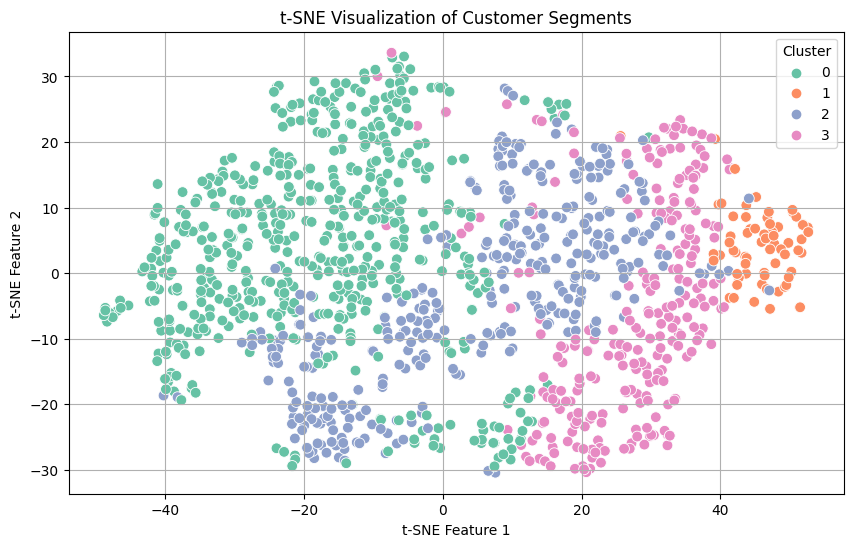

In [13]:
clustered_pandas = clustered_df.select("features", "cluster").toPandas()


X = np.array([np.array(vec.toArray()) for vec in clustered_pandas["features"]])
y = clustered_pandas["cluster"]

# Reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)


# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set2', s=60)
plt.title("t-SNE Visualization of Customer Segments")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Kmeans from scratch using map reduce

In [29]:
from pyspark.ml.linalg import Vectors
import numpy as np

def euclidean_dist(v1, v2):
    return np.linalg.norm(v1 - v2)

def kmeans_map_reduce(assembled_scaled, k=3, max_iterations=10):
    # Extract the feature vectors from the "features" column and convert to RDD
    feature_rdd = assembled_scaled.rdd.map(lambda row: np.array(row['features'].toArray()))  # Convert SparseVector to array

    # Initialize random centroids
    centroids = feature_rdd.takeSample(False, k, seed=123)

    def closest_centroid(point, centroids):
        distances = [np.linalg.norm(point - centroid) for centroid in centroids]
        return np.argmin(distances)

    for iteration in range(max_iterations):
        print(f"Iteration {iteration + 1} started")

        # Assign points to the closest centroid
        clustered_points = feature_rdd.map(lambda point: (closest_centroid(point, centroids), (point, 1)))

        # Sum points assigned to each centroid and count them
        cluster_sums = clustered_points.reduceByKey(
            lambda a, b: (a[0] + b[0], a[1] + b[1])
        )

        # Compute new centroids
        new_centroids = cluster_sums.mapValues(
            lambda v: v[0] / v[1]
        ).sortByKey().map(lambda x: x[1]).collect()

        # Check convergence
        tolerance = 1e-4
        converged_centroids = 0
        
        for old, new in zip(centroids, new_centroids):
            distance = euclidean_dist(old, new)
            if distance < tolerance:
                converged_centroids += 1
        
        if converged_centroids >= k * 0.9:  # 80% convergence
            print("Centroids converged!")
            break
        
        centroids = new_centroids

        print(f"Iteration {iteration + 1} completed")

    return centroids


In [30]:
final_centroids = kmeans_map_reduce(assembled_scaled, k=4, max_iterations=50)


Iteration 1 started
Iteration 1 completed
Iteration 2 started
Iteration 2 completed
Iteration 3 started
Iteration 3 completed
Iteration 4 started
Iteration 4 completed
Iteration 5 started
Iteration 5 completed
Iteration 6 started
Iteration 6 completed
Iteration 7 started
Iteration 7 completed
Iteration 8 started
Iteration 8 completed
Iteration 9 started
Iteration 9 completed
Iteration 10 started
Iteration 10 completed
Iteration 11 started
Iteration 11 completed
Iteration 12 started
Iteration 12 completed
Iteration 13 started
Iteration 13 completed
Iteration 14 started
Iteration 14 completed
Iteration 15 started
Iteration 15 completed
Iteration 16 started
Iteration 16 completed
Iteration 17 started
Iteration 17 completed
Iteration 18 started
Iteration 18 completed
Iteration 19 started
Iteration 19 completed
Iteration 20 started
Iteration 20 completed
Iteration 21 started
Centroids converged!


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def plot_clusters_sns(assembled_scaled, final_centroids):
    # Extract the feature vectors from the "features" column and convert to an RDD of numpy arrays
    feature_rdd = assembled_scaled.rdd.map(lambda row: np.array(row['features'].toArray()))  # Convert SparseVector to array
    points = feature_rdd.collect()

    # Step 1: Assign each point to its nearest centroid
    def closest_centroid(point, centroids):
        distances = [np.linalg.norm(point - centroid) for centroid in centroids]
        return np.argmin(distances)

    # Assign labels to each point based on its closest centroid
    labels = [closest_centroid(point, final_centroids) for point in points]
    
    # Step 2: Prepare data for t-SNE
    points_np = np.array(points)
    
    # Step 3: t-SNE only on points (not centroids)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    points_2d = tsne.fit_transform(points_np)

    # Step 4: Scatter plot with Seaborn
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=points_2d[:, 0], y=points_2d[:, 1], hue=labels, palette='Set2', s=60)

    plt.title("t-SNE Visualization of Customer Segments")
    plt.xlabel("t-SNE Feature 1")
    plt.ylabel("t-SNE Feature 2")
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()


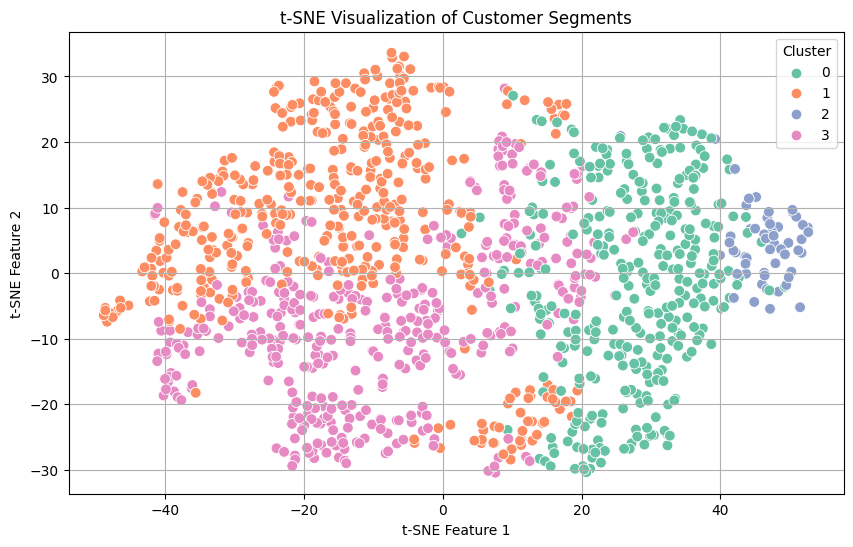

In [32]:
plot_clusters_sns(assembled_scaled, final_centroids)
